In [32]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys
sys.path.append('../')
from utils import matplotlib_setup
from os.path import join
from collections import defaultdict
import pandas as pd
from glob import glob
%matplotlib inline


In [33]:
patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]

In [34]:
def plot_bars(dt_bars, rf_bars, cnn_bars):
    
    matplotlib_setup( fontsize=35)

    barWidth = 0.25

    # Set position of bar on X axis
    r1 = np.arange(len( dt_bars))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    
    # Make the plot
    fig, ax = plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(18,6))
    ax.grid(linewidth=3,axis='y', color='grey')
    plt.bar(r1, dt_bars,  width=barWidth, edgecolor='white', label='Decision Tree', hatch=patterns[0])
    plt.bar(r2,  rf_bars, width=barWidth, edgecolor='white', label='Random Forest',hatch=patterns[1])
    plt.bar(r3,  cnn_bars,  width=barWidth, edgecolor='white', label='CNN',hatch=patterns[2])
 
    # Add xticks on the middle of the group bars
    plt.xticks([r + barWidth for r in range(len( dt_bars))], [ 'FFS', 'SFS', 'SGS', 'SRS'])
    
    plt.legend(ncol=3,fancybox=True, framealpha=0.3)
    return plt

In [4]:
clf_fingerprints = {}
clf_fingerprints['cnn'] ='c_cnn_optim_Adam_lr_0.001_reg_0_bs_4096_b_explicit'
clf_fingerprints['rf'] ='c_forest_b_explicit_n_100_bootstrap_True_mf_auto_msl_3_ms_0.01_md_25'
clf_fingerprints['dt'] ='c_tree_b_explicit_mf_auto_msl_3_md_25'

def read_dr(fn):
    df = pd.read_csv(fn)
    res = df[df['Label']=='Macro Average of Attacks']['Rc'].values[0]
    return res

def get_dr_ws(det_metric):
    result = defaultdict(list)
    d = '/data/juma/data/ids18/CSVs_r_1.0_m_1.0/WS_l'
    fn_exp = join(d,'{}','recall','fold_test{}.csv'.format(det_metric))
    for key, val in clf_fingerprints.items():
        result[key].append(read_dr(fn_exp.format(val)))
    return result

def get_dr(rdir,det_metric):
    #result = get_dr_ws(det_metric)
    result = defaultdict(list)
    for sdir in sorted(glob(join(rdir,'*_l'))):
        fn_exp = join(sdir,'{}','K_10','recall','fold_avg_{}.csv'.format(det_metric))
        for key, val in clf_fingerprints.items():
            result[key].append(read_dr(fn_exp.format(val)))
    return result


In [5]:
def get_ben_obsr_rate(d):
    df = pd.read_csv(join(d,'observation_rate.csv'))
    return df[df['Label']=='Benign']['Observation rate'].values[0]

def read_far(fn, ben_obsr):
    df = pd.read_csv(fn)
    ben_recall_eval = df[df['Label']=='Benign']['Rc'].values[0]
    res = 100-ben_recall_eval   
    return res*ben_obsr/100.

def get_far_ws(det_metric, ben_obsr):
    result = defaultdict(list)
    d = '/data/juma/data/ids18/CSVs_r_1.0_m_1.0/WS_l'
    fn_exp = join(d,'{}','eval','fold_test{}.csv'.format(det_metric))
    for key, val in clf_fingerprints.items():
        result[key].append(read_far(fn_exp.format(val),ben_obsr))
    return result

def get_far(rdir,det_metric):
    #esult = get_far_ws(det_metric,100.)
    result = defaultdict(list)
    for sdir in sorted(glob(join(rdir,'*_l'))):
        ben_obsr = get_ben_obsr_rate(sdir)
        fn_exp = join(sdir,'{}','K_10','eval','fold_avg_{}.csv'.format(det_metric))
        for key, val in clf_fingerprints.items():
            result[key].append(read_far(fn_exp.format(val),ben_obsr))
    return result


- FAR: groundth truth is total #benignFlows in complete traffic

$(100-benign_{relRecall})*\frac{benign_{observationRate}}{100} = benign_{observationRate} - benign_{observationRate}\frac{benign_{relRecall}}{100}$  

In [56]:
far_ylim = [0,40]
def plot_figures(dataroot, dr_ylim=[], far_ylim=[]):
    for det_metric in ['any', 'majority', 'all']:
        det_rates = get_dr(dataroot,det_metric)
        
        plot_bars(det_rates['dt'],det_rates['rf'], det_rates['cnn'])
        if len(dr_ylim):
            plt.ylim(dr_ylim)
        plt.ylabel('Detection Rate (%)\n Det. Met.: {}'.format(det_metric))
        plt.tight_layout()
        plt.savefig(join(dataroot,'tpr_{}.png'.format(det_metric)))
        plt.show()

        fa_rates = get_far(dataroot,det_metric)
        print('fa rates', fa_rates)
        plot_bars(fa_rates['dt'],fa_rates['rf'], fa_rates['cnn'])
        if len(far_ylim):
            plt.ylim(far_ylim)
        plt.ylabel('FAR(%)\n Det. Met.: {}'.format(det_metric))
        plt.tight_layout()
        plt.savefig(join(dataroot,'far_{}.png'.format(det_metric)))
        plt.show()

det_rates =  defaultdict(<class 'list'>, {'cnn': [72.22, 77.21, 76.06, 69.72], 'rf': [73.71, 79.97, 77.82, 72.77], 'dt': [69.23, 74.85, 75.48, 69.52]})


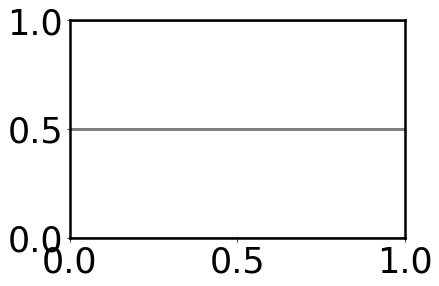

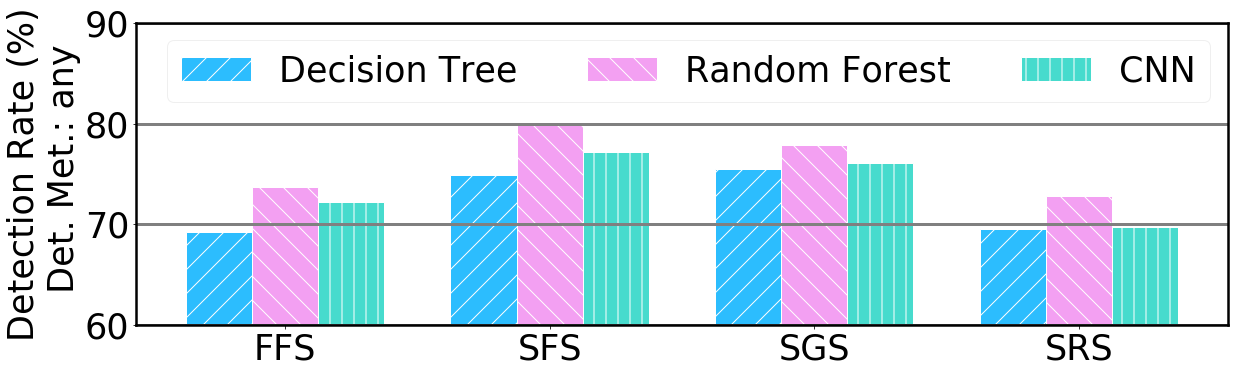

4.8700000000000045 56.24
0.9899999999999949 56.24
3.319999999999993 56.24
4.170000000000002 59.91
0.5799999999999983 59.91
3.0900000000000034 59.91
4.319999999999993 62.81
0.7800000000000011 62.81
1.8599999999999994 62.81
4.599999999999994 55.16
0.8599999999999994 55.16
1.5699999999999932 55.16


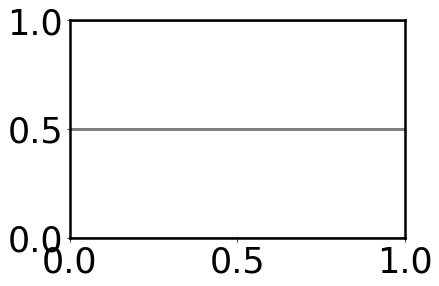

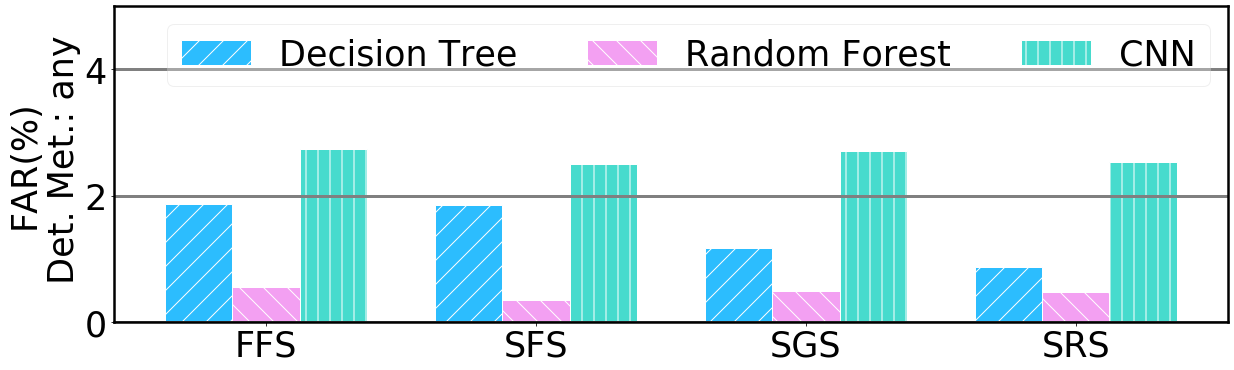

det_rates =  defaultdict(<class 'list'>, {'cnn': [71.71, 77.21, 75.31, 69.55], 'rf': [73.42, 79.96, 77.21, 72.77], 'dt': [67.95, 73.82, 74.52, 69.38]})


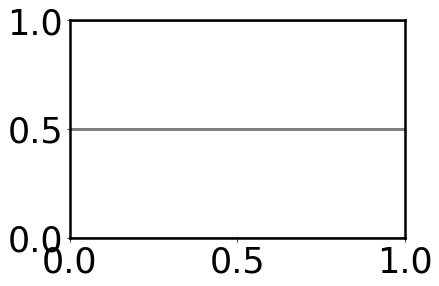

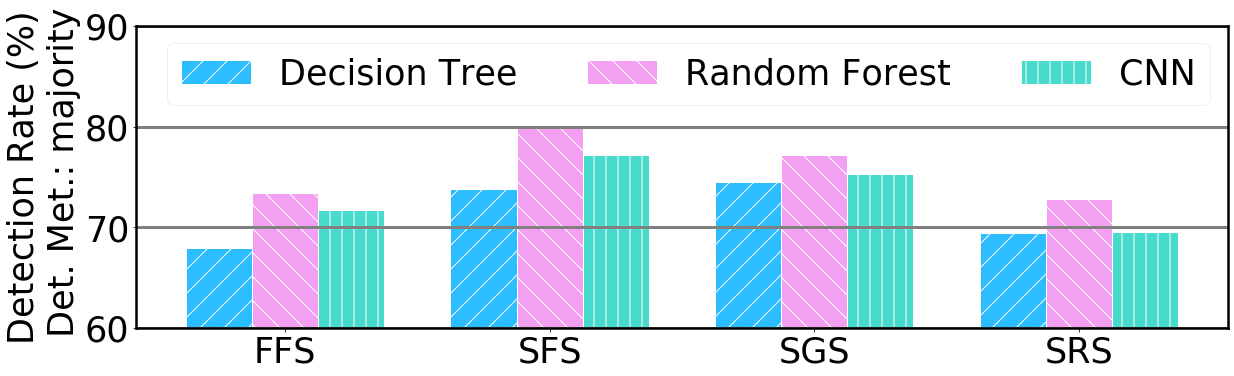

5.189999999999998 56.24
1.0100000000000051 56.24
3.4099999999999966 56.24
4.700000000000003 59.91
0.5999999999999943 59.91
3.450000000000003 59.91
4.799999999999997 62.81
0.8100000000000023 62.81
2.0 62.81
5.030000000000001 55.16
0.8799999999999955 55.16
1.6500000000000057 55.16


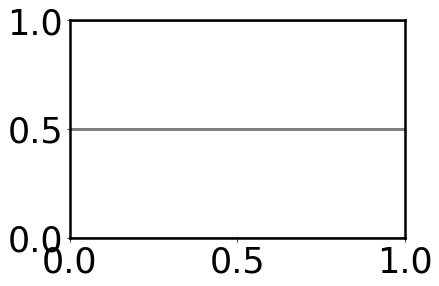

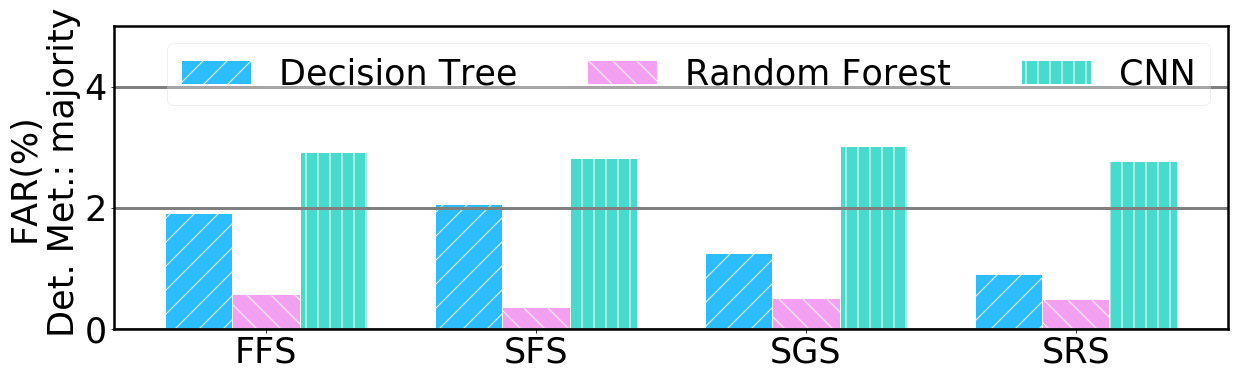

det_rates =  defaultdict(<class 'list'>, {'cnn': [71.22, 76.92, 74.87, 69.49], 'rf': [73.4, 79.94, 77.07, 72.74], 'dt': [65.22, 71.67, 73.65, 67.92]})


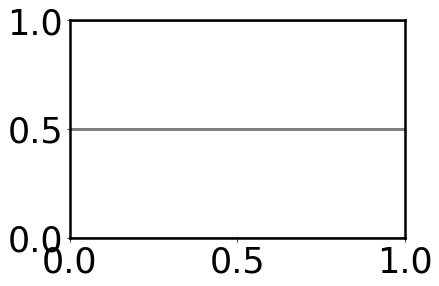

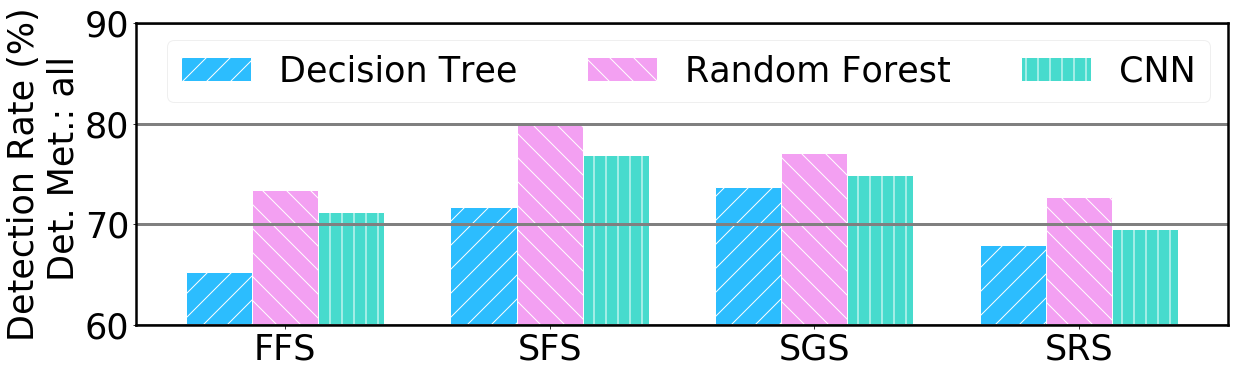

6.3799999999999955 56.24
1.5 56.24
5.060000000000002 56.24
5.200000000000003 59.91
0.9399999999999977 59.91
5.349999999999994 59.91
6.209999999999994 62.81
1.4200000000000017 62.81
3.8299999999999983 62.81
5.920000000000002 55.16
1.3799999999999955 55.16
2.719999999999999 55.16


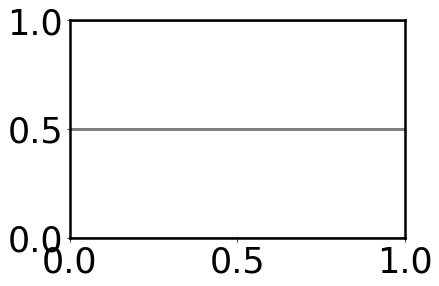

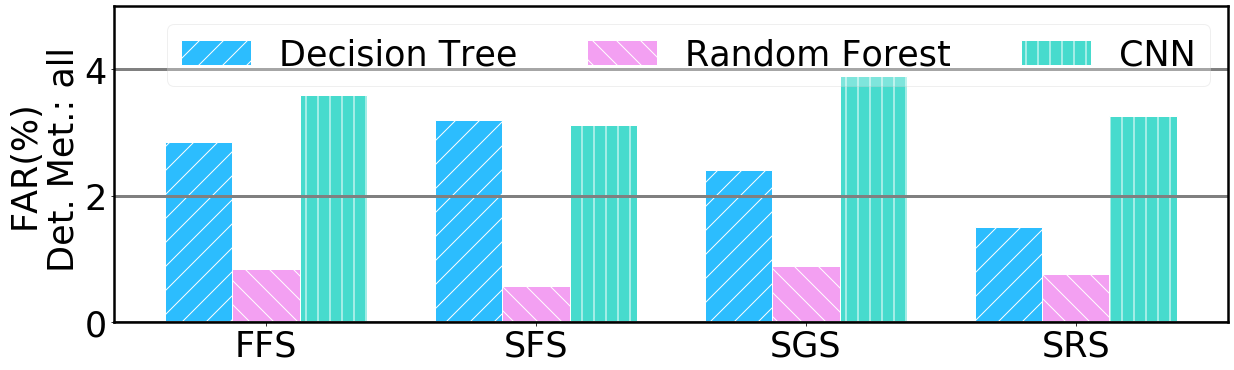

In [27]:
plot_figures('/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SI_10/', dr_ylim=[60,90], far_ylim=[0, 5])

det_rates =  defaultdict(<class 'list'>, {'cnn': [34.75, 34.78, 37.23, 34.83], 'rf': [36.95, 37.13, 39.05, 37.91], 'dt': [34.78, 35.35, 35.77, 34.95]})


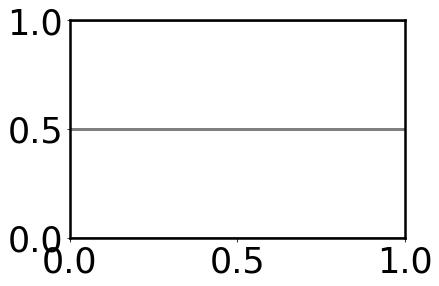

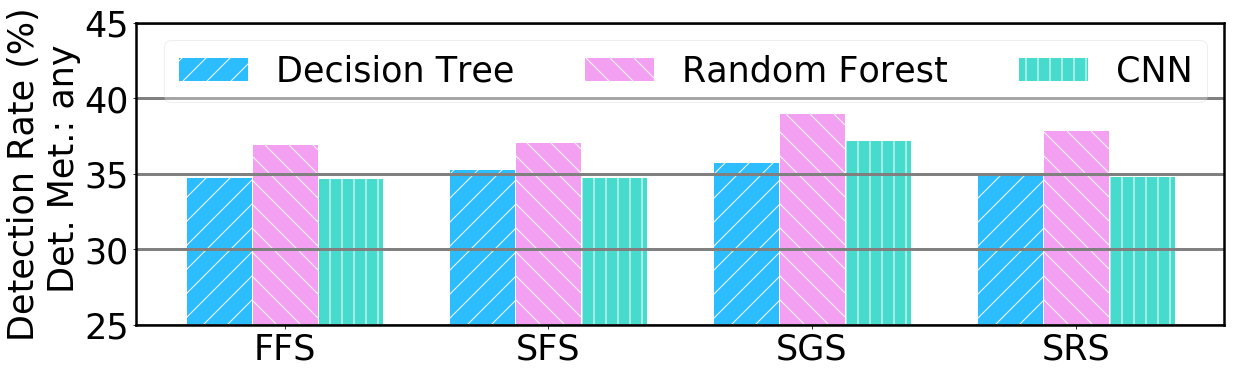

11.530000000000001 11.89
3.4200000000000017 11.89
4.540000000000006 11.89
6.560000000000002 10.29
1.8700000000000045 10.29
6.420000000000002 10.29
18.439999999999998 15.82
6.090000000000003 15.82
7.569999999999993 15.82
12.5 11.34
4.340000000000003 11.34
4.459999999999994 11.34


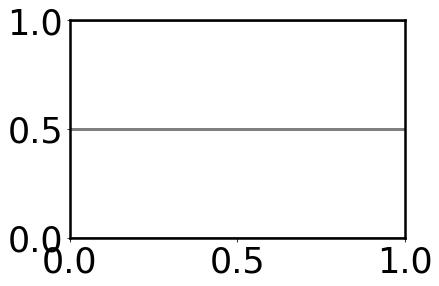

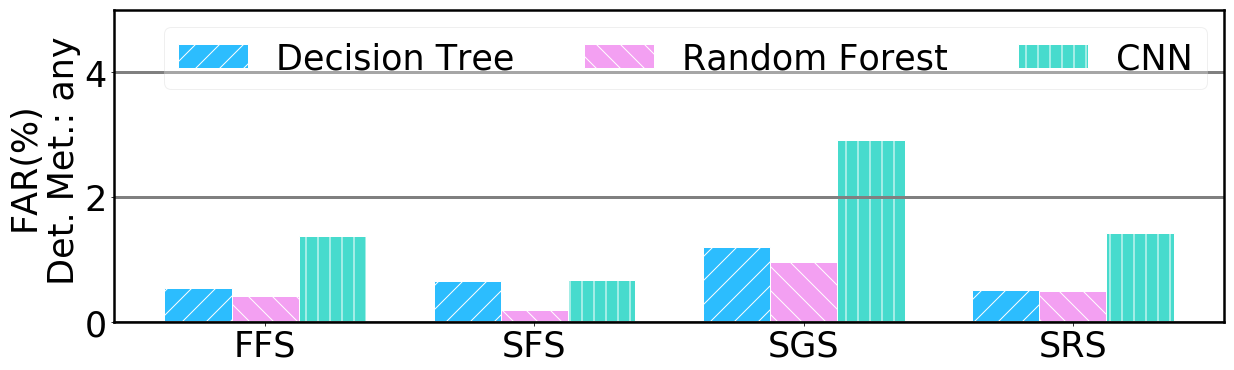

det_rates =  defaultdict(<class 'list'>, {'cnn': [34.61, 34.78, 37.01, 34.81], 'rf': [36.76, 37.13, 39.01, 37.91], 'dt': [34.64, 35.08, 35.12, 34.76]})


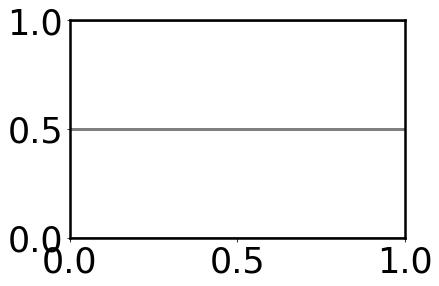

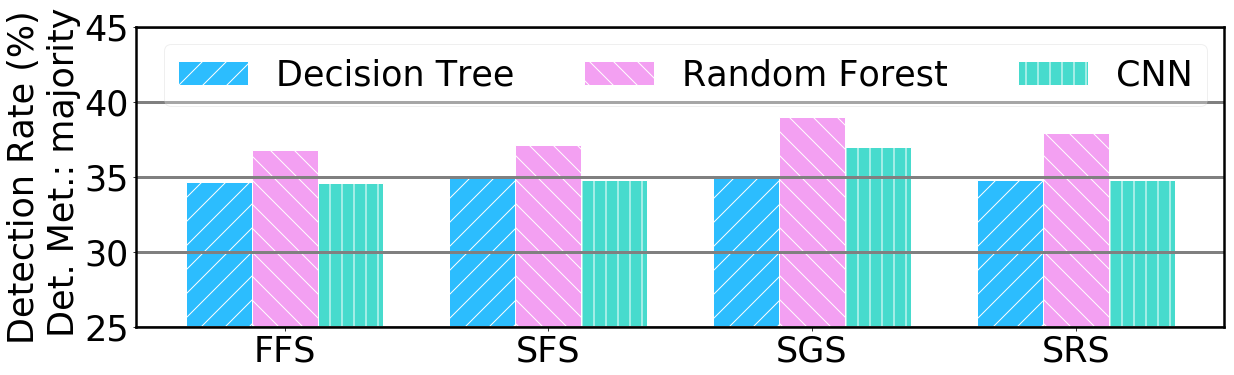

11.569999999999993 11.89
3.4200000000000017 11.89
4.549999999999997 11.89
6.569999999999993 10.29
1.8799999999999955 10.29
6.439999999999998 10.29
18.519999999999996 15.82
6.109999999999999 15.82
7.590000000000003 15.82
12.549999999999997 11.34
4.349999999999994 11.34
4.469999999999999 11.34


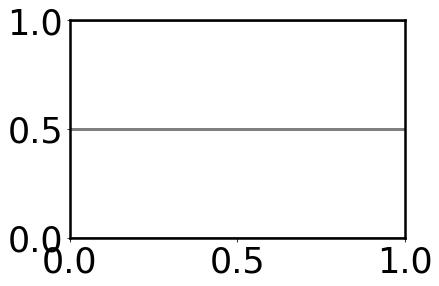

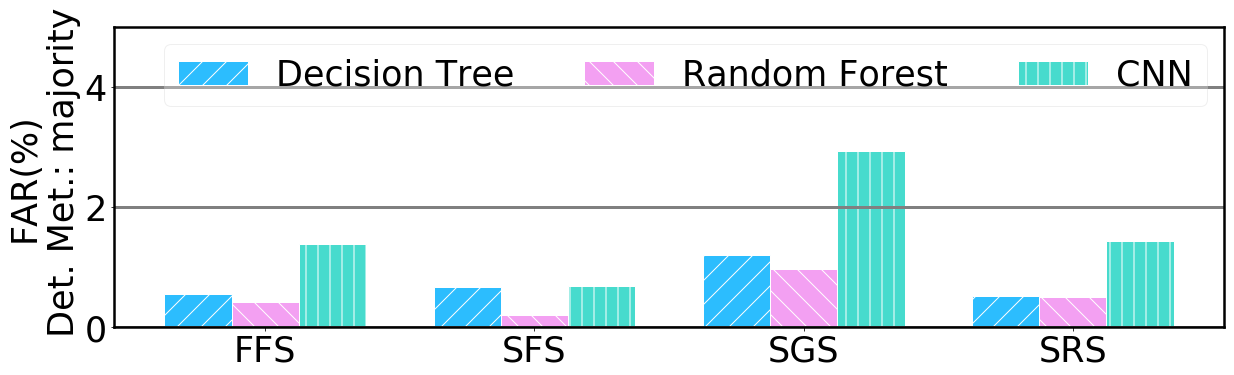

det_rates =  defaultdict(<class 'list'>, {'cnn': [33.9, 34.77, 36.89, 34.53], 'rf': [36.75, 37.11, 38.97, 37.9], 'dt': [34.46, 33.23, 34.64, 33.78]})


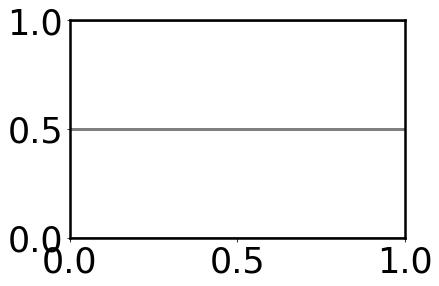

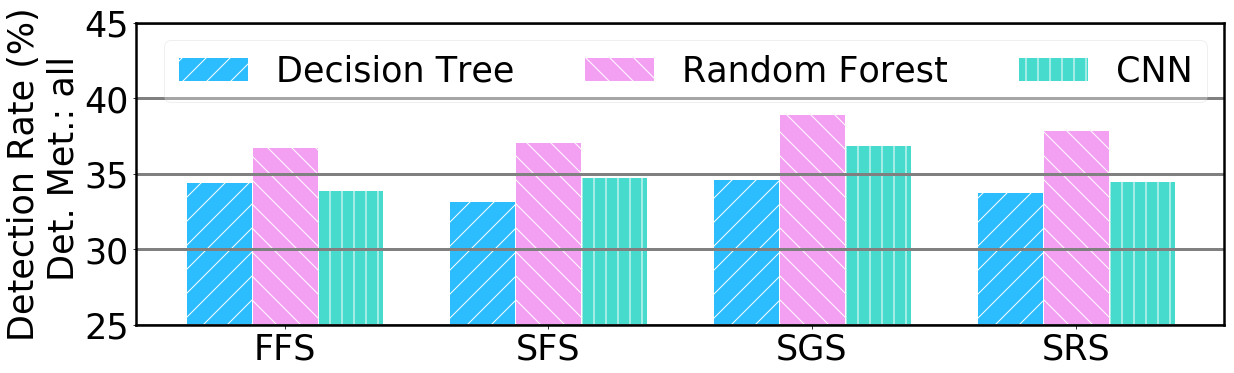

12.150000000000006 11.89
3.9000000000000057 11.89
4.909999999999997 11.89
6.680000000000007 10.29
1.9699999999999989 10.29
6.650000000000006 10.29
19.700000000000003 15.82
6.840000000000003 15.82
8.349999999999994 15.82
13.159999999999997 11.34
4.8799999999999955 11.34
4.8700000000000045 11.34


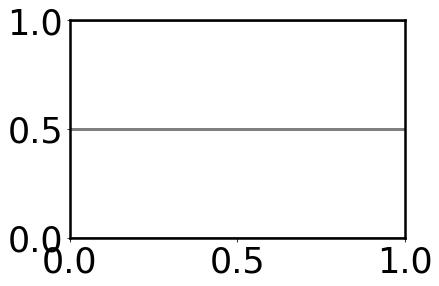

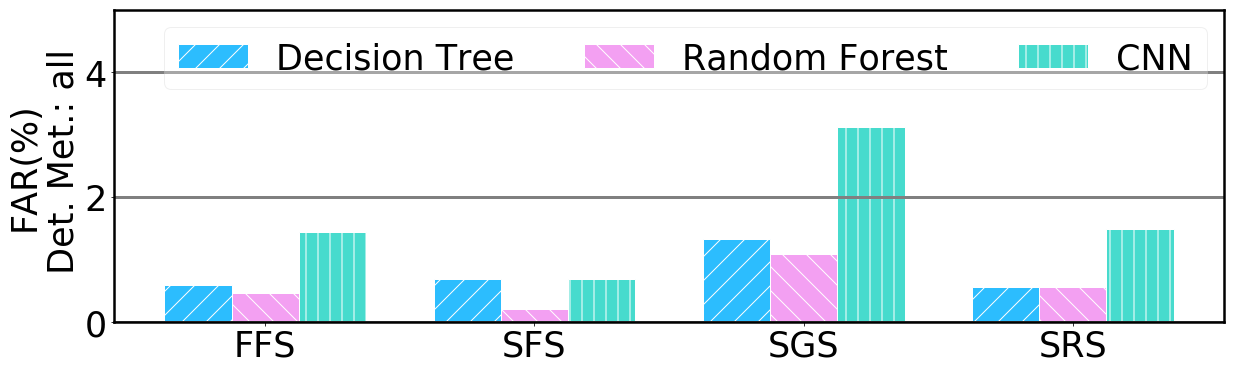

In [187]:
plot_figures('/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SI_100/', dr_ylim=[25,45], far_ylim = [0, 5])

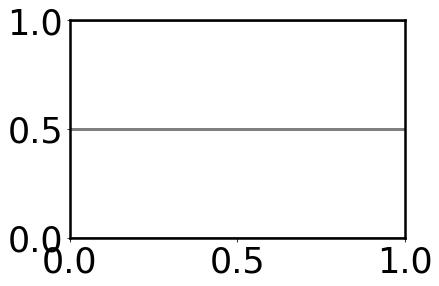

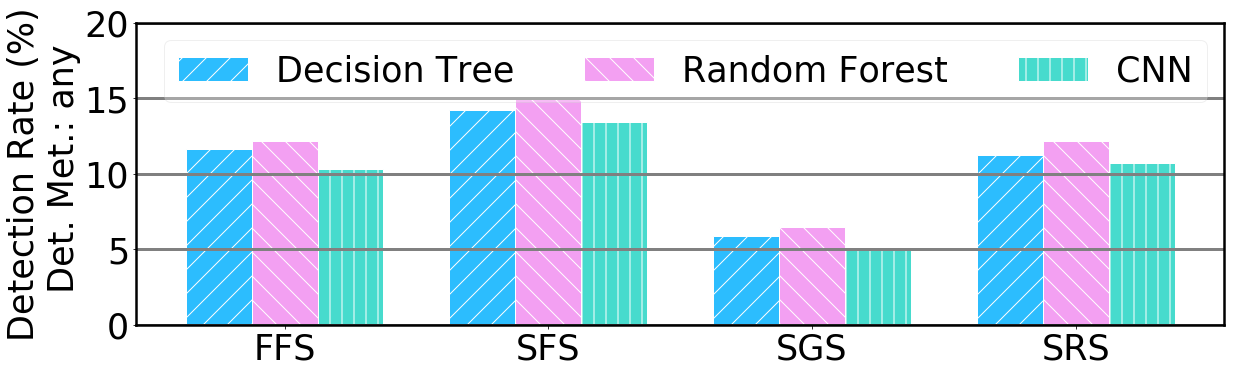

fa rates defaultdict(<class 'list'>, {'cnn': [0.4848659999999999, 0.222507, 1.295619, 0.509018], 'rf': [0.18907000000000004, 0.03021300000000003, 0.6794770000000002, 0.161379], 'dt': [0.14570800000000006, 0.07913699999999997, 0.339858, 0.21753500000000006]})


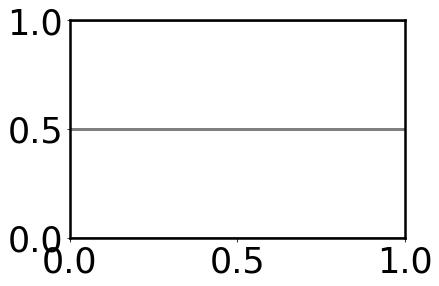

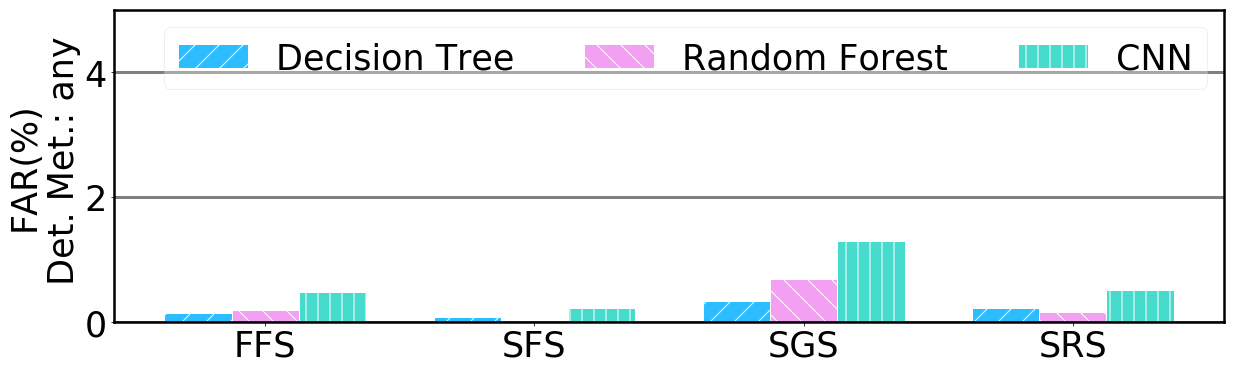

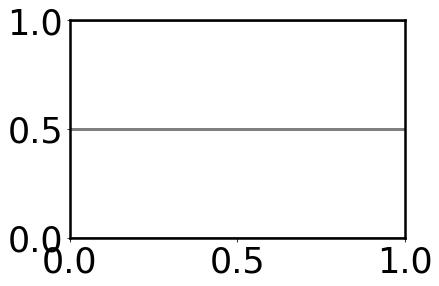

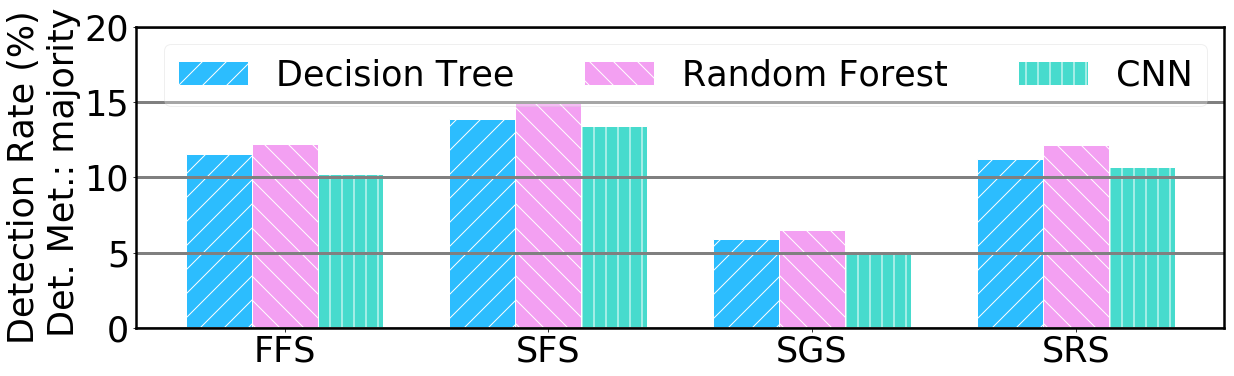

fa rates defaultdict(<class 'list'>, {'cnn': [0.485012, 0.22299300000000002, 1.295619, 0.509296], 'rf': [0.1898, 0.03029399999999996, 0.6794770000000002, 0.16165699999999994], 'dt': [0.14585399999999993, 0.07946100000000002, 0.339858, 0.21767399999999995]})


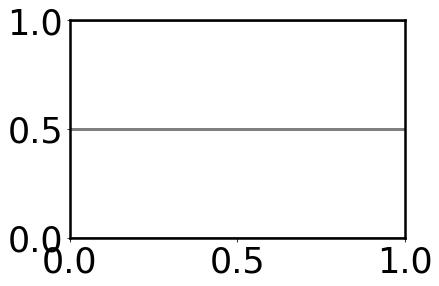

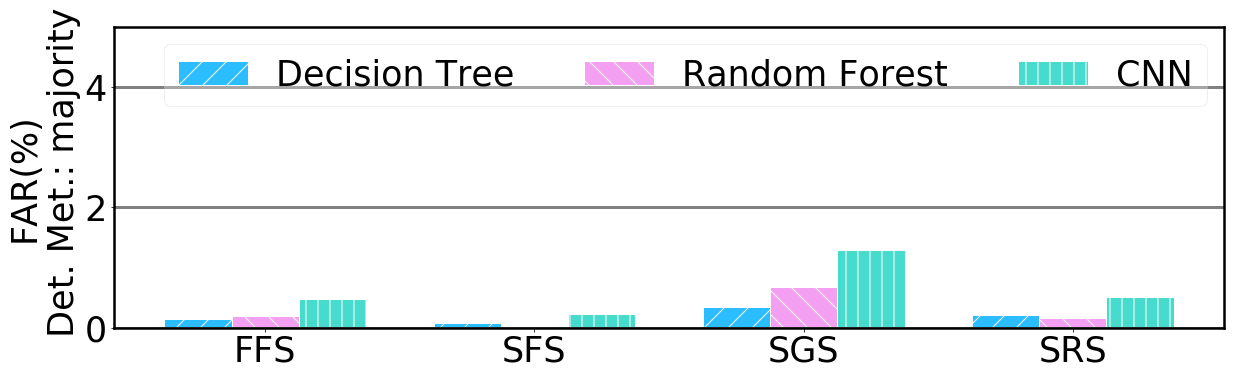

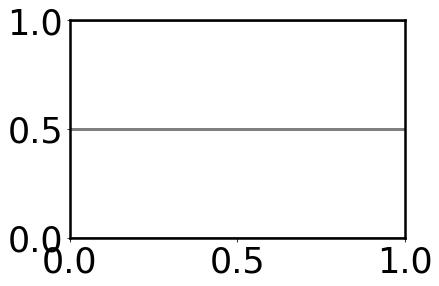

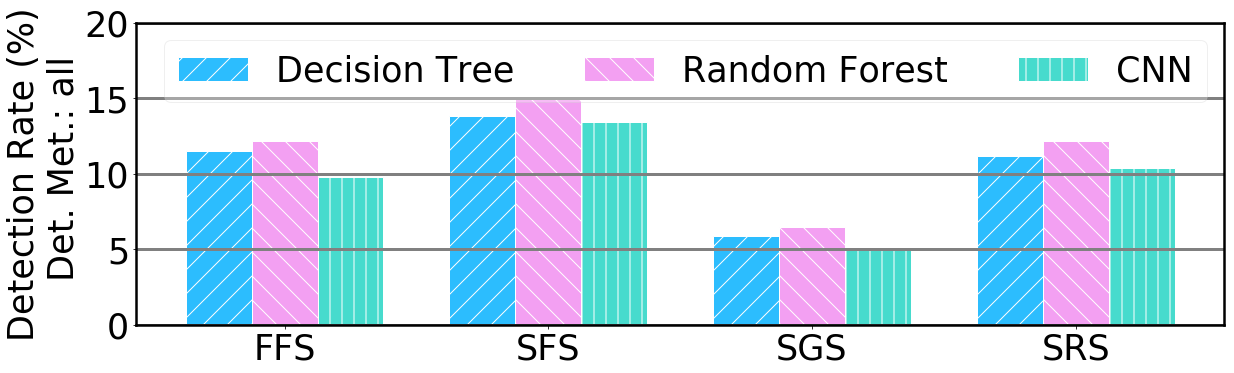

fa rates defaultdict(<class 'list'>, {'cnn': [0.48749400000000004, 0.225828, 1.295858, 0.51152], 'rf': [0.193888, 0.031184999999999956, 0.6799550000000001, 0.165688], 'dt': [0.14731400000000006, 0.08140499999999998, 0.3403359999999999, 0.22003699999999995]})


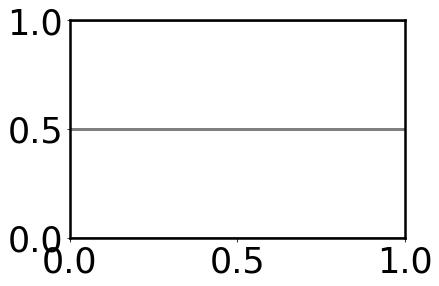

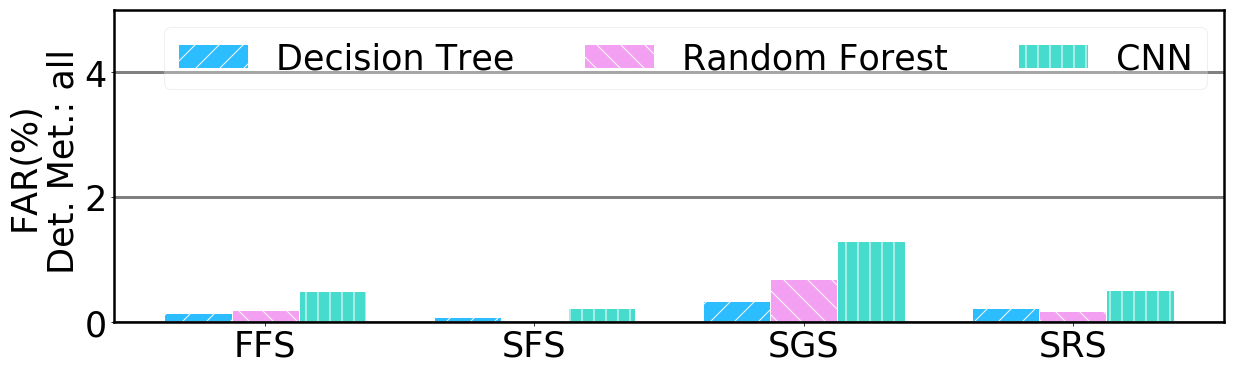

In [193]:
plot_figures('/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SI_1000/', dr_ylim=[0,20],far_ylim=[0, 5])

# Plot on single figure by subplots for IEEE Access

In [34]:
def plot_bars_on_ax(ax,dt_bars, rf_bars, cnn_bars):
    
    matplotlib_setup( fontsize=35)

    # set width of bar
    barWidth = 0.25

    # Set position of bar on X axis
    r1 = np.arange(len( dt_bars))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    
    # Make the plot
    ax.grid(linewidth=3,axis='y', color='grey')
    ax.bar(r1, dt_bars,  width=barWidth, edgecolor='white', label='Decision Tree', hatch=patterns[0])
    ax.bar(r2,  rf_bars, width=barWidth, edgecolor='white', label='Random Forest',hatch=patterns[1])
    ax.bar(r3,  cnn_bars,  width=barWidth, edgecolor='white', label='CNN',hatch=patterns[2])
 
    # Add xticks on the middle of the group bars
    #plt.xticks([r + barWidth for r in range(len( dt_bars))], [ 'FFS', 'SFS', 'SGS', 'SRS'])
    ax.set_xticks([r + barWidth for r in range(len( dt_bars))])
    ax.set_xticklabels([ 'FFS', 'SFS', 'SGS', 'SRS'])
    
    # Create legend & Show graphic
    ax.legend(ncol=3,fancybox=True, framealpha=0.3)
    

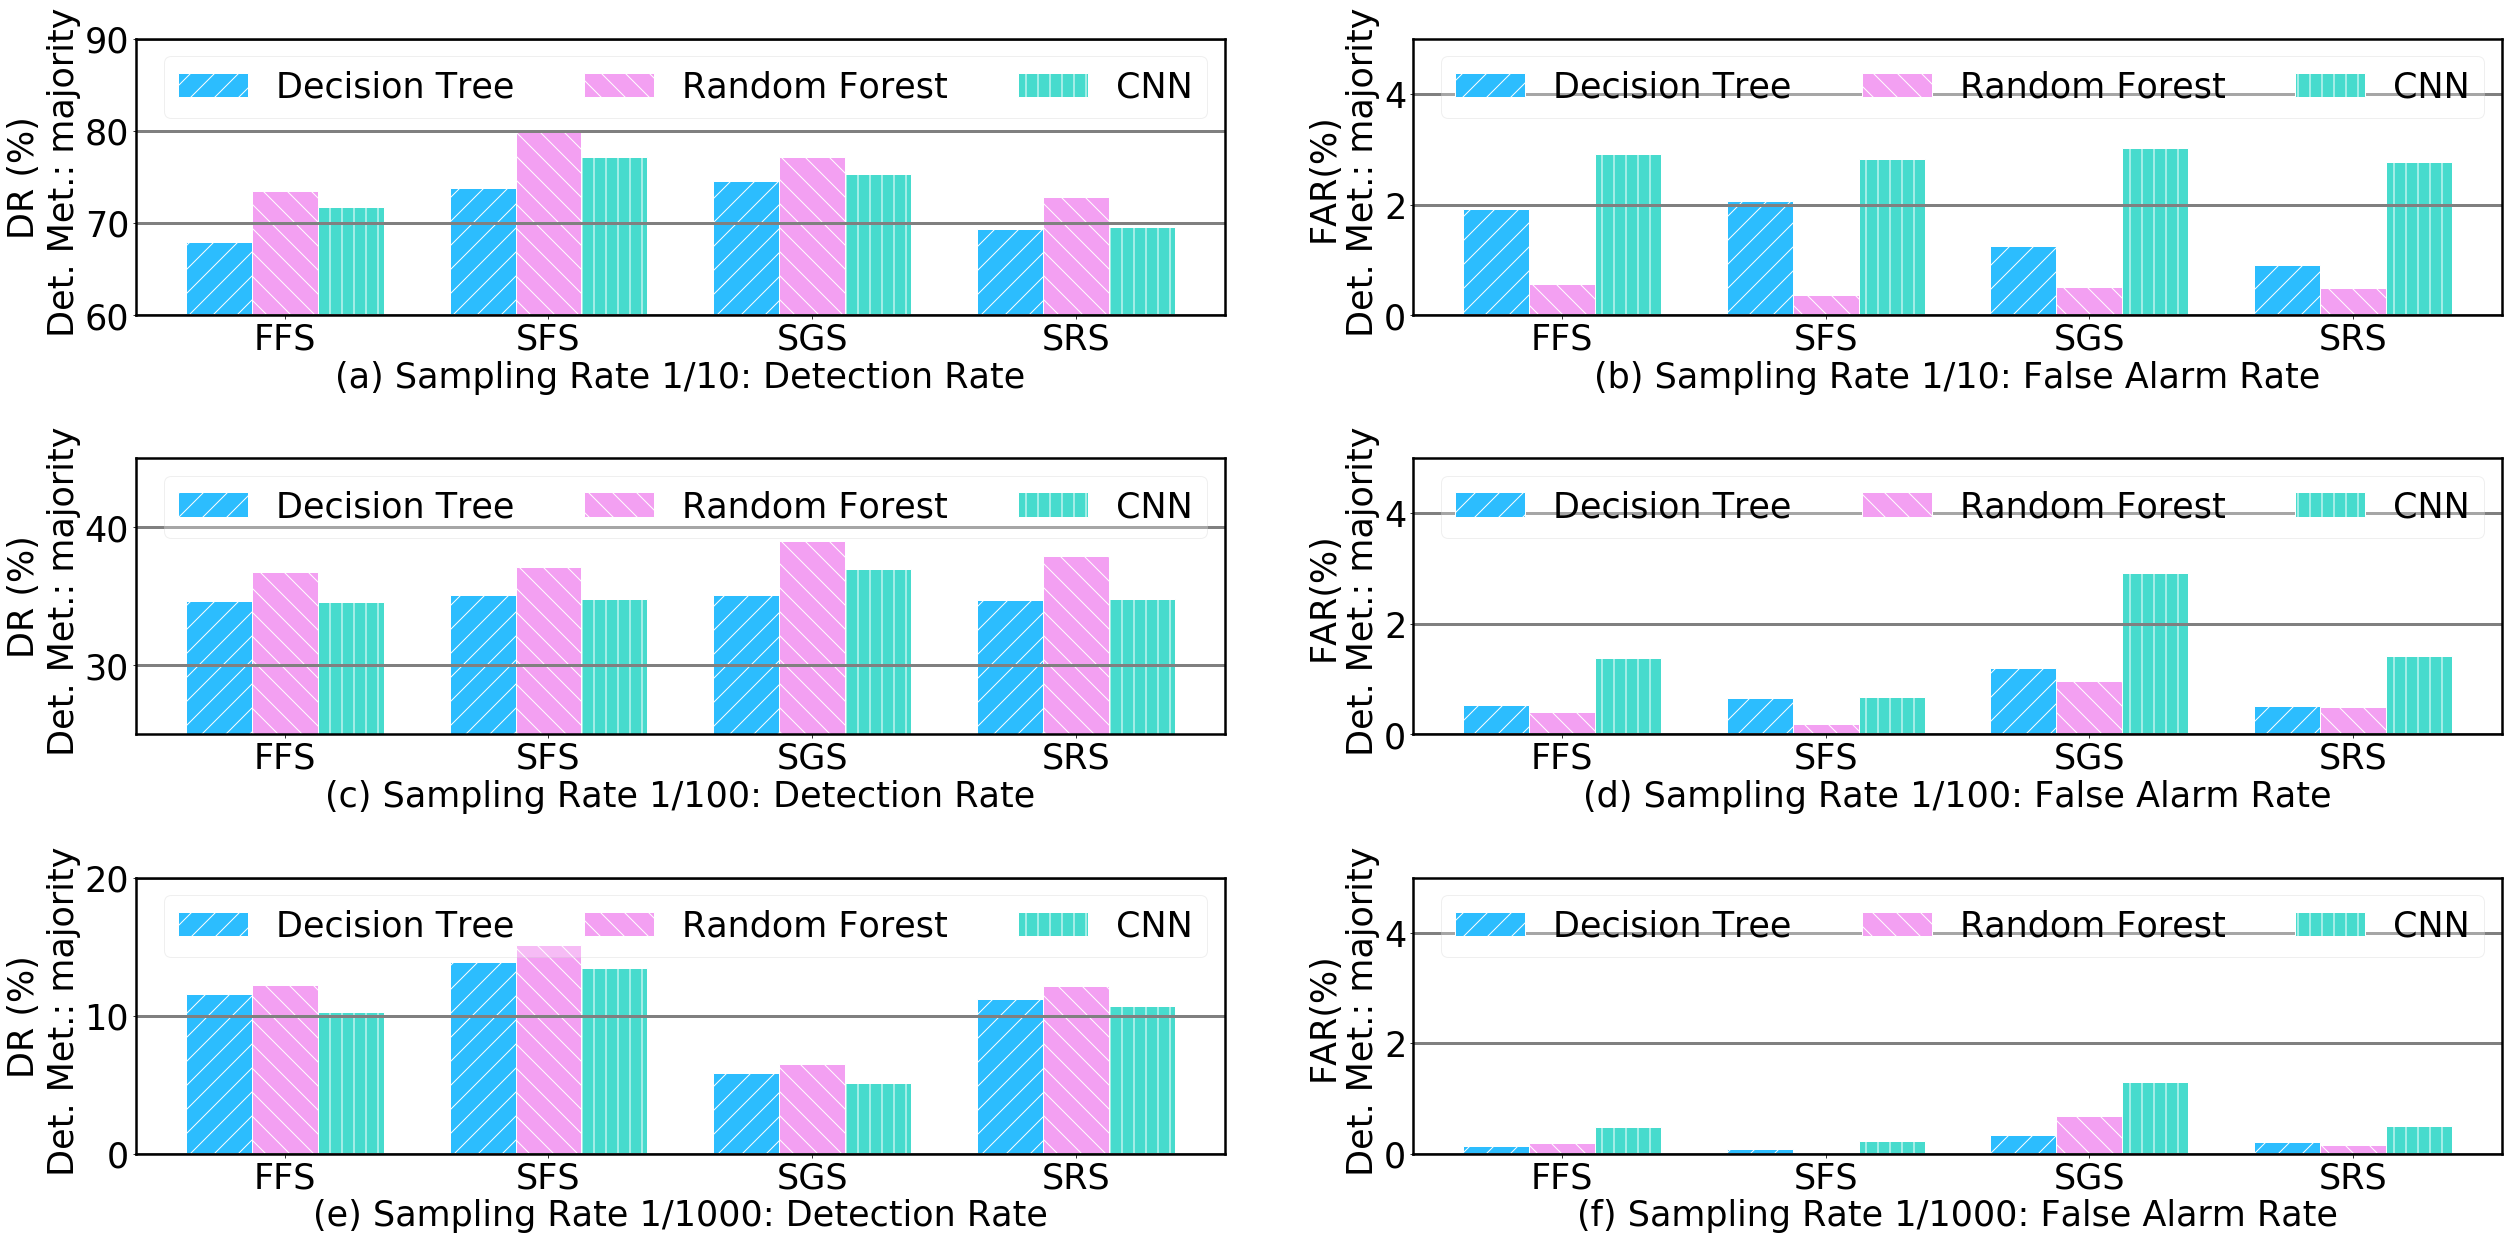

In [42]:
far_ylim = [0,40]
fig, axes = plt.subplots(3,2, figsize=(36,18))
DET_METRIC = 'majority'
def plot_figures_dr(ax1, dataroot, dr_ylim=[], sr_str=''):
        det_rates = get_dr(dataroot,DET_METRIC)
        
        plot_bars_on_ax(ax1,det_rates['dt'],det_rates['rf'], det_rates['cnn'])
        if len(dr_ylim):
            ax1.set_ylim(dr_ylim)
        ax1.set_ylabel('DR (%)\n Det. Met.: {}'.format(DET_METRIC))
        ax1.set_xlabel(sr_str)
        

def plot_figures_far(ax2, dataroot, far_ylim=[], sr_str=''):
        fa_rates = get_far(dataroot,DET_METRIC)
        plot_bars_on_ax(ax2, fa_rates['dt'],fa_rates['rf'], fa_rates['cnn'])
        if len(far_ylim):
            ax2.set_ylim(far_ylim)
        ax2.set_ylabel('FAR(%)\n Det. Met.: {}'.format(DET_METRIC))
        ax2.set_xlabel(sr_str)

        
plot_figures_dr(axes[0,0],'/data/juma/data/net_intrusion/ids18/CSVs_r_1.0_m_1.0/SI_10/',
                    dr_ylim=[60,90], sr_str='(a) Sampling Rate 1/10: Detection Rate')
plot_figures_far(axes[0,1],'/data/juma/data/net_intrusion/ids18/CSVs_r_1.0_m_1.0/SI_10/',
                    far_ylim=[0, 5], sr_str='(b) Sampling Rate 1/10: False Alarm Rate')

plot_figures_dr(axes[1,0],'/data/juma/data/net_intrusion/ids18/CSVs_r_1.0_m_1.0/SI_100/',
                    dr_ylim=[25,45], sr_str='(c) Sampling Rate 1/100: Detection Rate')
plot_figures_far(axes[1,1],'/data/juma/data/net_intrusion/ids18/CSVs_r_1.0_m_1.0/SI_100/',
                    far_ylim=[0, 5], sr_str='(d) Sampling Rate 1/100: False Alarm Rate')

plot_figures_dr(axes[2,0],'/data/juma/data/net_intrusion/ids18/CSVs_r_1.0_m_1.0/SI_1000/',
                    dr_ylim=[0,20], sr_str='(e) Sampling Rate 1/1000: Detection Rate')
plot_figures_far(axes[2,1],'/data/juma/data/net_intrusion/ids18/CSVs_r_1.0_m_1.0/SI_1000/',
                    far_ylim=[0, 5], sr_str='(f) Sampling Rate 1/1000: False Alarm Rate')


fig.tight_layout()
plt.savefig('/data/juma/data/net_intrusion/ids18/ML_on_sampler.png')
plt.show()


## Evaluation in multiple thresholds
- here we vary the threshold for benign catagory in flow record level predictions
    - if $prob^{benign}>max(prob^{attack_i})$ then it is considered as benign
    - else predicted category for the record is $argmax(prob^{attack_i})$

In [147]:
import ntpath


DET_METRIC = 'majority'
srdir = '/data/juma/data/net_intrusion/ids18/CSVs_r_1.0_m_1.0/SI_1000/'
sr_fars  = {}
sr_drs = {}
THRESHOLDS = []
for sampler_dir in glob(join(srdir,'*_l')):
    sampler = ntpath.basename(sampler_dir)
    ben_obsr = get_ben_obsr_rate(sampler_dir)
    clf_fars = {}
    clf_drs = {}
    for key, clf_fingerprint in clf_fingerprints.items():
   
        drs = [read_dr(join(kfold_dir,'recall','fold_avg_majority.csv')) for kfold_dir in glob(join(sampler_dir,clf_fingerprint, 'K_10_ben*'))]
        fn_exp = join('{}','eval','fold_avg_{}.csv'.format(DET_METRIC))
        fars = [read_far(fn_exp.format(kfold_dir), ben_obsr) for kfold_dir in glob(join(sampler_dir,clf_fingerprint, 'K_10_ben*'))]
        basenames = [ntpath.basename(kfold_dir) for kfold_dir in glob(join(sampler_dir,clf_fingerprint, 'K_10_ben*'))]
        thresholds = np.array([float(b[b.rfind('_')+1:]) for b in basenames])
        
        indices = np.argsort(thresholds)
        THRESHOLDS = thresholds[indices]
#         print(THRESHOLDS, len(THRESHOLDS))
#         print(sampler_dir, key,np.array(drs)[indices])
#         print(sampler_dir, key,np.array(fars)[indices])
        clf_fars[key]=np.array(fars)[indices]
        clf_drs[key]=np.array(drs)[indices]
    sr_fars[sampler]=clf_fars
    sr_drs[sampler]=clf_drs


In [157]:
import ntpath


DET_METRIC = 'majority'
srdir = '/data/juma/data/net_intrusion/ids18/CSVs_r_1.0_m_1.0/SI_100/'
sr_fars  = {}
sr_drs = {}
THRESHOLDS = []
for sampler_dir in glob(join(srdir,'*_l')):
    sampler = ntpath.basename(sampler_dir)
    ben_obsr = get_ben_obsr_rate(sampler_dir)
    clf_fars = {}
    clf_drs = {}
    for key, clf_fingerprint in clf_fingerprints.items():
   
        drs = [read_dr(join(kfold_dir,'recall','fold_avg_majority.csv')) for kfold_dir in glob(join(sampler_dir,clf_fingerprint, 'K_10_ben*'))]
        fn_exp = join('{}','eval','fold_avg_{}.csv'.format(DET_METRIC))
        fars = [read_far(fn_exp.format(kfold_dir), ben_obsr) for kfold_dir in glob(join(sampler_dir,clf_fingerprint, 'K_10_ben*'))]
        basenames = [ntpath.basename(kfold_dir) for kfold_dir in glob(join(sampler_dir,clf_fingerprint, 'K_10_ben*'))]
        thresholds = np.array([float(b[b.rfind('_')+1:]) for b in basenames])
        
        indices = np.argsort(thresholds)
        THRESHOLDS = thresholds[indices]
#         print(THRESHOLDS, len(THRESHOLDS))
#         print(sampler_dir, key,np.array(drs)[indices])
#         print(sampler_dir, key,np.array(fars)[indices])
        clf_fars[key]=np.array(fars)[indices]
        clf_drs[key]=np.array(drs)[indices]
    sr_fars[sampler]=clf_fars
    sr_drs[sampler]=clf_drs


In [158]:
sr_fars

{'FFS_(8,16,40)_l': {'cnn': array([0.277037, 0.335298, 0.410205, 0.48749 , 0.60639 , 0.757393,
         0.965468, 1.215158, 1.375673, 1.375673]),
  'rf': array([0.      , 0.      , 0.001189, 0.003567, 0.009512, 0.027347,
         0.098687, 0.342432, 0.406638, 0.406638]),
  'dt': array([0.061828, 0.076096, 0.146247, 0.217587, 0.302006, 0.342432,
         0.426851, 0.521971, 0.540995, 0.540995])},
 'SGS_e_1_l': {'cnn': array([0.41132 , 0.591668, 0.80682 , 1.048866, 1.363684, 1.70065 ,
         2.07242 , 2.603972, 2.929864, 2.929864]),
  'rf': array([0.      , 0.      , 0.001582, 0.006328, 0.026894, 0.104412,
         0.351204, 0.835296, 0.966602, 0.966602]),
  'dt': array([0.121814, 0.148708, 0.21357 , 0.26894 , 0.420812, 1.015644,
         1.110564, 1.161188, 1.200738, 1.200738])},
 'SRS_SI_100_l': {'cnn': array([0.179172, 0.24948 , 0.337932, 0.458136, 0.603288, 0.756378,
         0.93555 , 1.229256, 1.42317 , 1.42317 ]),
  'rf': array([0.      , 0.      , 0.001134, 0.003402, 0.013608, 

In [141]:
len(THRESHOLDS)

10

In [143]:
sr_fars.keys()

dict_keys(['SGS_e_11.5_l', 'FFS_(8,16,400)_l', 'SFS_SI_685.08_l', 'SRS_SI_1000_l'])

In [144]:
sr_fars['SGS_e_11.5_l']

{'cnn': array([], dtype=float64),
 'rf': array([0.00000e+00, 0.00000e+00, 2.39000e-04, 2.86800e-03, 1.95980e-02,
        9.94240e-02, 3.42965e-01, 6.35501e-01, 6.79477e-01, 6.79477e-01]),
 'dt': array([0.041825, 0.05975 , 0.083172, 0.111852, 0.14579 , 0.184986,
        0.300423, 0.338902, 0.339858, 0.339858])}

In [77]:
%load_ext rpy2.ipython

In [78]:
%%R 
library (tibble)
library(dplyr)
library(forcats)
library(tidyr)
library(purrr)
library(psych)
library(stringr)
library(ggplot2)
library(ggridges)
library(viridis)

THEME_DEFAULT <- theme_bw(
    base_size=10,
    base_family='Arial'
) +
theme(
    axis.title.x=element_text(colour="grey20",size=13,angle=0,hjust=.5,vjust=.5, face="bold"),
    axis.title.y=element_text(colour="grey20",size=13,angle=90,hjust=.5,vjust=1, face="bold"),
    axis.text.x=element_text(colour="grey20",size=11,angle=0,hjust=.5,vjust=.5),
    axis.text.y=element_text(colour="grey20",size=11,angle=0,hjust=.5,vjust=.5),
    strip.text.x=element_text(colour="grey20",size=13,angle=0,hjust=0.5,vjust=.25, face="bold"),
    strip.text.y=element_text(colour="grey20",size=13,angle=270,hjust=.5,vjust=.5, face="bold"),
    legend.title=element_text(colour="grey20",size=13,angle=0,hjust=0.5,vjust=.5,face="bold"),
    legend.position='top'
)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘ggplot2’


R[write to console]: The following objects are masked from ‘package:psych’:

    %+%, alpha


R[write to console]: Loading required package: viridisLite



In [159]:
sr_ls = []
for sampler,v in sr_fars.items():
    sampler_ls = []
    for clf, fars in v.items():
        print(sampler, clf)
        print('len(fars) = ', len(fars))
        df_clf = pd.DataFrame({'far':fars, 'thresholds':THRESHOLDS})
        df_clf.insert(0, 'classifier',clf, allow_duplicates=True)
        print(sampler, clf, df_clf.shape)
        sampler_ls.append(df_clf)
    df_sampler = pd.concat(sampler_ls)
    df_sampler.insert(0, 'sampler',sampler[:3],allow_duplicates=True)
    sr_ls.append(df_sampler)
df_si_1000 = pd.concat(sr_ls)
outfile = 'multiple_thresholds'


df_si_100 = df_si_1000.copy(deep=True)
df_si_10 = df_si_1000.copy(deep=True)
df_si_1000.insert(0,'sampling_rate','SR 1/1000', allow_duplicates=True)
df_si_100.insert(0,'sampling_rate','SR 1/100', allow_duplicates=True)
df_si_10.insert(0,'sampling_rate','SR 1/10', allow_duplicates=True)
df = pd.concat([df_si_10,df_si_100, df_si_1000])
df

FFS_(8,16,40)_l cnn
len(fars) =  10
FFS_(8,16,40)_l cnn (10, 3)
FFS_(8,16,40)_l rf
len(fars) =  10
FFS_(8,16,40)_l rf (10, 3)
FFS_(8,16,40)_l dt
len(fars) =  10
FFS_(8,16,40)_l dt (10, 3)
SGS_e_1_l cnn
len(fars) =  10
SGS_e_1_l cnn (10, 3)
SGS_e_1_l rf
len(fars) =  10
SGS_e_1_l rf (10, 3)
SGS_e_1_l dt
len(fars) =  10
SGS_e_1_l dt (10, 3)
SRS_SI_100_l cnn
len(fars) =  10
SRS_SI_100_l cnn (10, 3)
SRS_SI_100_l rf
len(fars) =  10
SRS_SI_100_l rf (10, 3)
SRS_SI_100_l dt
len(fars) =  10
SRS_SI_100_l dt (10, 3)
SFS_SI_95.33_l cnn
len(fars) =  10
SFS_SI_95.33_l cnn (10, 3)
SFS_SI_95.33_l rf
len(fars) =  10
SFS_SI_95.33_l rf (10, 3)
SFS_SI_95.33_l dt
len(fars) =  10
SFS_SI_95.33_l dt (10, 3)


,sampling_rate,sampler,classifier,far,thresholds
0,SR 1/10,FFS,cnn,0.277037,0.010
1,SR 1/10,FFS,cnn,0.335298,0.017
2,SR 1/10,FFS,cnn,0.410205,0.028
3,SR 1/10,FFS,cnn,0.487490,0.046
4,SR 1/10,FFS,cnn,0.606390,0.077
...,...,...,...,...,...
5,SR 1/1000,SFS,dt,0.435267,0.129
6,SR 1/1000,SFS,dt,0.595791,0.215
7,SR 1/1000,SFS,dt,0.662676,0.359
8,SR 1/1000,SFS,dt,0.662676,0.599


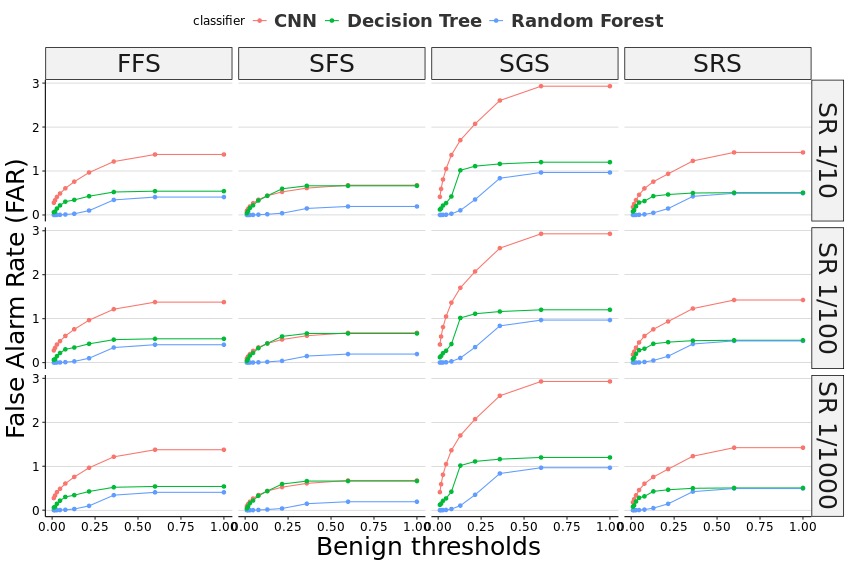

In [160]:
%%R -i df -i outfile -w 30 -h 20 -u cm
library(ggsci) 
library(ggpubr)

df <- df %>% mutate(
    classifier = case_when(
        classifier == 'dt' ~ 'Decision Tree',
        classifier == 'rf' ~ 'Random Forest',
        classifier == 'cnn' ~ 'CNN',
    )
)

ggplot(data=df, aes(x=thresholds, y=far, color=classifier))+
  geom_line()+
  geom_point()+
    labs(x='Benign thresholds',
        y='False Alarm Rate (FAR)'
        )+
  facet_grid(
              rows = vars(sampling_rate),
             cols=vars(sampler)
         ) +
    theme_pubr()+
    theme(
        panel.grid.major.y = element_line(size=0.25, linetype='solid', color='grey'),
        panel.grid.minor.y = element_line(size=0.01, linetype='solid', color='grey'),

        legend.text=element_text(colour="grey20", size=18, angle=0, hjust=.0, face='bold'),
        strip.text = element_text(size=25),
         axis.title = element_text(size=25),
         )

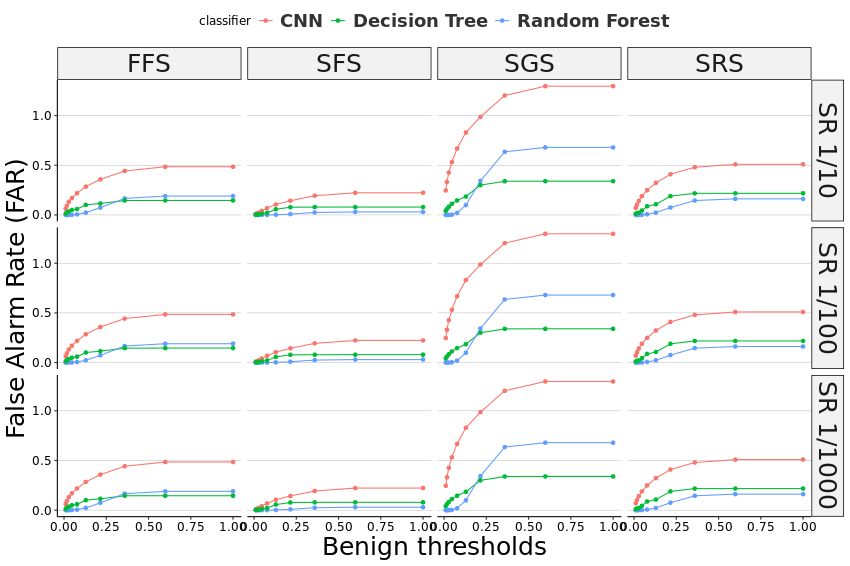

In [149]:
%%R -i df -i outfile -w 30 -h 20 -u cm
library(ggsci) 
library(ggpubr)

df <- df %>% mutate(
    classifier = case_when(
        classifier == 'dt' ~ 'Decision Tree',
        classifier == 'rf' ~ 'Random Forest',
        classifier == 'cnn' ~ 'CNN',
    )
)

ggplot(data=df, aes(x=thresholds, y=far, color=classifier))+
  geom_line()+
  geom_point()+
    labs(x='Benign thresholds',
        y='False Alarm Rate (FAR)'
        )+
  facet_grid(
              rows = vars(sampling_rate),
             cols=vars(sampler)
         ) +
    theme_pubr()+
    theme(
        panel.grid.major.y = element_line(size=0.25, linetype='solid', color='grey'),
        panel.grid.minor.y = element_line(size=0.01, linetype='solid', color='grey'),

        legend.text=element_text(colour="grey20", size=18, angle=0, hjust=.0, face='bold'),
        strip.text = element_text(size=25),
         axis.title = element_text(size=25),
         )

In [150]:
sr_ls = []
for sampler,v in sr_drs.items():
    sampler_ls = []
    for clf, drs in v.items():
        df_clf = pd.DataFrame({'dr':drs, 'thresholds':THRESHOLDS})
        df_clf.insert(0, 'classifier',clf, allow_duplicates=True)
        sampler_ls.append(df_clf)
    df_sampler = pd.concat(sampler_ls)
    df_sampler.insert(0, 'sampler',sampler[:3],allow_duplicates=True)
    sr_ls.append(df_sampler)
df_si_1000 = pd.concat(sr_ls)
outfile = 'multiple_thresholds'


df_si_100 = df_si_1000.copy(deep=True)
df_si_10 = df_si_1000.copy(deep=True)
df_si_1000.insert(0,'sampling_rate','SR 1/1000', allow_duplicates=True)
df_si_100.insert(0,'sampling_rate','SR 1/100', allow_duplicates=True)
df_si_10.insert(0,'sampling_rate','SR 1/10', allow_duplicates=True)
df = pd.concat([df_si_10,df_si_100, df_si_1000])
df

,sampling_rate,sampler,classifier,dr,thresholds
0,SR 1/10,SGS,cnn,2.10,0.010
1,SR 1/10,SGS,cnn,2.70,0.017
2,SR 1/10,SGS,cnn,3.26,0.028
3,SR 1/10,SGS,cnn,3.65,0.046
4,SR 1/10,SGS,cnn,3.90,0.077
...,...,...,...,...,...
5,SR 1/1000,SRS,dt,10.67,0.129
6,SR 1/1000,SRS,dt,10.70,0.215
7,SR 1/1000,SRS,dt,10.79,0.359
8,SR 1/1000,SRS,dt,10.79,0.599


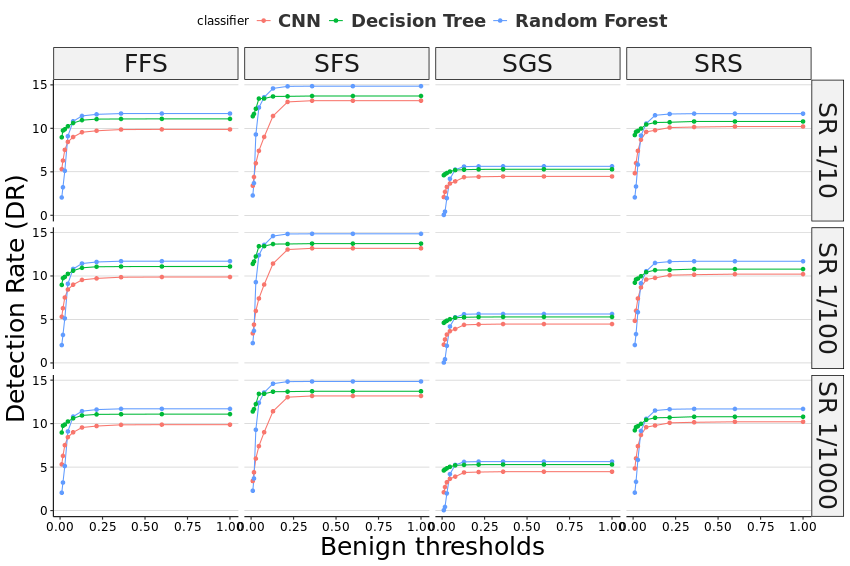

In [151]:
%%R -i df -i outfile -w 30 -h 20 -u cm
library(ggsci) 
library(ggpubr)

df <- df %>% mutate(
    classifier = case_when(
        classifier == 'dt' ~ 'Decision Tree',
        classifier == 'rf' ~ 'Random Forest',
        classifier == 'cnn' ~ 'CNN',
    )
)

ggplot(data=df, aes(x=thresholds, y=dr, color=classifier))+
  geom_line()+
  geom_point()+
    labs(x='Benign thresholds',
        y='Detection Rate (DR)'
        )+
  facet_grid(
              rows = vars(sampling_rate),
             cols=vars(sampler)
         )  +
    theme_pubr()+
    theme(
        panel.grid.major.y = element_line(size=0.25, linetype='solid', color='grey'),
        panel.grid.minor.y = element_line(size=0.01, linetype='solid', color='grey'),

        legend.text=element_text(colour="grey20", size=18, angle=0, hjust=.0, face='bold'),
        strip.text = element_text(size=25),
         axis.title = element_text(size=25),
         )

c_cnn_optim_Adam_lr_0.001_reg_0_bs_4096_b_explicit
['K_10_benign_threshold_0.359', 'K_10_benign_threshold_0.046', 'K_10_benign_threshold_0.129', 'K_10_benign_threshold_0.017', 'K_10_benign_threshold_0.028', 'K_10_benign_threshold_0.215', 'K_10_benign_threshold_0.077', 'K_10_benign_threshold_0.599', 'K_10_benign_threshold_0.01', 'K_10_benign_threshold_1.0']
thsho [0.359 0.046 0.129 0.017 0.028 0.215 0.077 0.599 0.01  1.   ]
[0.01  0.017 0.028 0.046 0.077 0.129 0.215 0.359 0.599 1.   ]
c_forest_b_explicit_n_100_bootstrap_True_mf_auto_msl_3_ms_0.01_md_25
['K_10_benign_threshold_0.359', 'K_10_benign_threshold_0.046', 'K_10_benign_threshold_0.129', 'K_10_benign_threshold_0.017', 'K_10_benign_threshold_0.028', 'K_10_benign_threshold_0.215', 'K_10_benign_threshold_0.077', 'K_10_benign_threshold_0.599', 'K_10_benign_threshold_0.01', 'K_10_benign_threshold_1.0']
thsho [0.359 0.046 0.129 0.017 0.028 0.215 0.077 0.599 0.01  1.   ]
[0.01  0.017 0.028 0.046 0.077 0.129 0.215 0.359 0.599 1.   ]
c_tr

FileNotFoundError: [Errno 2] No such file or directory: '/data/juma/data/net_intrusion/ids18/CSVs_r_1.0_m_1.0/SI_100/SRS_SI_100_l/c_tree_b_explicit_mf_auto_msl_3_md_25/K_10_0.01/recall/fold_avg_majority.csv'

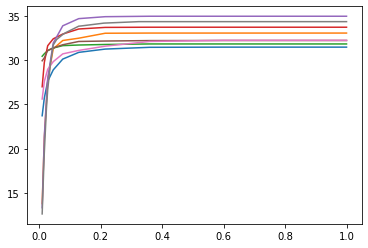

In [154]:
DET_METRIC = 'majority'
srdir = '/data/juma/data/net_intrusion/ids18/CSVs_r_1.0_m_1.0/SI_100/'
clf_fingerprint = 'c_forest_b_explicit_n_100_bootstrap_True_mf_auto_msl_3_ms_0.01_md_25'
for sampler_dir in glob(join(srdir,'*_l')):

    ben_obsr = get_ben_obsr_rate(sampler_dir)
    for key, clf_fingerprint in clf_fingerprints.items():

        print(clf_fingerprint)
        drs = [read_dr(join(kfold_dir,'recall','fold_avg_majority.csv')) for kfold_dir in glob(join(sampler_dir,clf_fingerprint, 'K_10_*'))]
        fn_exp = join('{}','eval','fold_avg_{}.csv'.format(DET_METRIC))
        fars = [read_far(fn_exp.format(kfold_dir), ben_obsr) for kfold_dir in glob(join(sampler_dir,clf_fingerprint, 'K_10_*'))]

        basenames = [ntpath.basename(kfold_dir) for kfold_dir in glob(join(sampler_dir,clf_fingerprint, 'K_10_*'))]
        print(basenames)
        thresholds = np.array([float(b[b.rfind('_')+1:]) for b in basenames])
        print('thsho', thresholds)
        
        indices = np.argsort(thresholds)
        print(thresholds[indices])
        plt.plot(thresholds[indices],np.array(drs)[indices])

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## ANOVA test

conducted for each sampler
 - for each classifier
    - for each fold

### Detection rate

In [54]:
import ntpath
from scipy import stats
DET_METRIC = 'majority'
K = 10
def get_dr_perfold(srdir,det_metric):
    test_res = []
    sampler_names = []
    for samplerdir in sorted(glob(join(srdir,'*_l'))):
        clf_results = {}
        for key, clf_fingerprint in clf_fingerprints.items():
            fn_exp = join(srdir,samplerdir,clf_fingerprint,'K_10','recall')
            clf_results[key] = [read_dr(join(fn_exp,'fold_{}_{}.csv'.format(fold_index,det_metric))) for fold_index in range(K)]
        F, p = stats.f_oneway(clf_results['dt'], clf_results['rf'], clf_results['cnn'])
        if round(p,3)==0:
            test_res.append('F(2,27) = {:6.3f}, p<0.001'.format(F))
        else:
            test_res.append('F(2,27) = {:6.3f}, p={:.3f}'.format(F,p))
            
        sampler_names.append(ntpath.basename(samplerdir))
    return sampler_names, test_res

df = pd.DataFrame()

sampler_names, test_res1 = get_dr_perfold('/data/juma/data/net_intrusion/ids18/CSVs_r_1.0_m_1.0/SI_10/',DET_METRIC)
df.insert(0,'sampling technique',sampler_names)
df.insert(1,'sampling rate: 1/10',test_res1)

_, test_res2 = get_dr_perfold('/data/juma/data/net_intrusion/ids18/CSVs_r_1.0_m_1.0/SI_100/',DET_METRIC)
df.insert(2,'sampling rate: 1/100',test_res2)

_, test_res3 = get_dr_perfold('/data/juma/data/net_intrusion/ids18/CSVs_r_1.0_m_1.0/SI_1000/',DET_METRIC)
df.insert(3,'sampling rate: 1/1000',test_res3)
print(sampler_names, test_res)
df

['FFS_(8,16,4)_l', 'SFS_SI_9.77_l', 'SGS_e_0.05_l', 'SRS_SI_10_l'] ['F(2,27)=8.276, p=0.002', 'F(2,27)=12.074, p<0.001', 'F(2,27)=9.591, p=0.001', 'F(2,27)=18.307, p<0.001']


,sampling technique,sampling rate: 1/10,sampling rate: 1/100,sampling rate: 1/1000
0,"FFS_(8,16,4)_l","F(2,27) = 8.276, p=0.002","F(2,27) = 8.819, p=0.001","F(2,27) = 9.640, p=0.001"
1,SFS_SI_9.77_l,"F(2,27) = 12.074, p<0.001","F(2,27) = 6.755, p=0.004","F(2,27) = 5.523, p=0.010"
2,SGS_e_0.05_l,"F(2,27) = 9.591, p=0.001","F(2,27) = 1.912, p=0.167","F(2,27) = 28.998, p<0.001"
3,SRS_SI_10_l,"F(2,27) = 18.307, p<0.001","F(2,27) = 0.429, p=0.656","F(2,27) = 23.789, p<0.001"


In [55]:
df.set_index('sampling technique').transpose().to_csv('anova_test_for_sampled_record.csv')

### False alarm rate

In [69]:
import ntpath
from scipy import stats
DET_METRIC = 'majority'
K = 10
#        fn_exp = join(sdir,'{}','K_10','eval','fold_avg_{}.csv'.format(det_metric))
def anova_on_far_perfold(srdir,det_metric):
    test_res = []
    sampler_names = []
    for samplerdir in sorted(glob(join(srdir,'*_l'))):
        clf_results = {}
        ben_obsr = get_ben_obsr_rate(samplerdir)
        print("ben_obsr",ben_obsr)
        for key, clf_fingerprint in clf_fingerprints.items():
            fn_exp = join(srdir,samplerdir,clf_fingerprint,'K_10','eval')
            clf_results[key] = [read_far(join(fn_exp,'fold_{}_{}.csv'.format(fold_index,det_metric)),ben_obsr) for fold_index in range(K)]
            #clf_results[key]
            #print(res)
        F, p = stats.f_oneway(clf_results['dt'], clf_results['rf'], clf_results['cnn'])
        if round(p,3)==0:
            test_res.append('F(2,27) = {:6.3f}, p<0.001'.format(F))
        else:
            test_res.append('F(2,27) = {:6.3f}, p={:.3f}'.format(F,p))
            
        sampler_names.append(ntpath.basename(samplerdir))
    return sampler_names, test_res

df = pd.DataFrame()

sampler_names, test_res1 = anova_on_far_perfold('/data/juma/data/net_intrusion/ids18/CSVs_r_1.0_m_1.0/SI_10/',DET_METRIC)
df.insert(0,'sampling technique',sampler_names)
df.insert(1,'sampling rate: 1/10',test_res1)

_, test_res2 = anova_on_far_perfold('/data/juma/data/net_intrusion/ids18/CSVs_r_1.0_m_1.0/SI_100/',DET_METRIC)
df.insert(2,'sampling rate: 1/100',test_res2)

_, test_res3 = anova_on_far_perfold('/data/juma/data/net_intrusion/ids18/CSVs_r_1.0_m_1.0/SI_1000/',DET_METRIC)
df.insert(3,'sampling rate: 1/1000',test_res3)
print(sampler_names, test_res)
df

ben_obsr 56.24
type(ben_recall_eval) <class 'numpy.float64'> 93.49
res
type(ben_recall_eval) <class 'numpy.float64'> 94.94
res
type(ben_recall_eval) <class 'numpy.float64'> 95.69
res
type(ben_recall_eval) <class 'numpy.float64'> 94.75
res
type(ben_recall_eval) <class 'numpy.float64'> 94.61
res
type(ben_recall_eval) <class 'numpy.float64'> 94.54
res
type(ben_recall_eval) <class 'numpy.float64'> 93.3
res
type(ben_recall_eval) <class 'numpy.float64'> 94.82
res
type(ben_recall_eval) <class 'numpy.float64'> 96.39
res
type(ben_recall_eval) <class 'numpy.float64'> 95.58
res
type(ben_recall_eval) <class 'numpy.float64'> 99.0
res
type(ben_recall_eval) <class 'numpy.float64'> 99.03
res
type(ben_recall_eval) <class 'numpy.float64'> 99.05
res
type(ben_recall_eval) <class 'numpy.float64'> 98.97
res
type(ben_recall_eval) <class 'numpy.float64'> 98.99
res
type(ben_recall_eval) <class 'numpy.float64'> 98.9
res
type(ben_recall_eval) <class 'numpy.float64'> 98.93
res
type(ben_recall_eval) <class 'numpy.

type(ben_recall_eval) <class 'numpy.float64'> 94.53
res
type(ben_recall_eval) <class 'numpy.float64'> 90.93
res
type(ben_recall_eval) <class 'numpy.float64'> 91.33
res
type(ben_recall_eval) <class 'numpy.float64'> 98.15
res
type(ben_recall_eval) <class 'numpy.float64'> 94.14
res
type(ben_recall_eval) <class 'numpy.float64'> 94.66
res
type(ben_recall_eval) <class 'numpy.float64'> 97.08
res
type(ben_recall_eval) <class 'numpy.float64'> 97.57
res
ben_obsr 15.82
type(ben_recall_eval) <class 'numpy.float64'> 88.79
res
type(ben_recall_eval) <class 'numpy.float64'> 76.87
res
type(ben_recall_eval) <class 'numpy.float64'> 76.61
res
type(ben_recall_eval) <class 'numpy.float64'> 82.01
res
type(ben_recall_eval) <class 'numpy.float64'> 86.67
res
type(ben_recall_eval) <class 'numpy.float64'> 78.06
res
type(ben_recall_eval) <class 'numpy.float64'> 82.77
res
type(ben_recall_eval) <class 'numpy.float64'> 79.58
res
type(ben_recall_eval) <class 'numpy.float64'> 82.91
res
type(ben_recall_eval) <class 'num

ben_obsr 1.39
type(ben_recall_eval) <class 'numpy.float64'> 61.1
res
type(ben_recall_eval) <class 'numpy.float64'> 61.71
res
type(ben_recall_eval) <class 'numpy.float64'> 66.57
res
type(ben_recall_eval) <class 'numpy.float64'> 66.24
res
type(ben_recall_eval) <class 'numpy.float64'> 61.82
res
type(ben_recall_eval) <class 'numpy.float64'> 60.71
res
type(ben_recall_eval) <class 'numpy.float64'> 59.57
res
type(ben_recall_eval) <class 'numpy.float64'> 72.46
res
type(ben_recall_eval) <class 'numpy.float64'> 58.62
res
type(ben_recall_eval) <class 'numpy.float64'> 64.83
res
type(ben_recall_eval) <class 'numpy.float64'> 88.8
res
type(ben_recall_eval) <class 'numpy.float64'> 88.59
res
type(ben_recall_eval) <class 'numpy.float64'> 88.3
res
type(ben_recall_eval) <class 'numpy.float64'> 87.77
res
type(ben_recall_eval) <class 'numpy.float64'> 89.84
res
type(ben_recall_eval) <class 'numpy.float64'> 88.26
res
type(ben_recall_eval) <class 'numpy.float64'> 88.53
res
type(ben_recall_eval) <class 'numpy.f

,sampling technique,sampling rate: 1/10,sampling rate: 1/100,sampling rate: 1/1000
0,"FFS_(8,16,4)_l","F(2,27) = 4.068, p=0.029","F(2,27) = 23.051, p<0.001","F(2,27) = 44.499, p<0.001"
1,SFS_SI_9.77_l,"F(2,27) = 23.803, p<0.001","F(2,27) = 5.466, p=0.010","F(2,27) = 26.303, p<0.001"
2,SGS_e_0.05_l,"F(2,27) = 45.341, p<0.001","F(2,27) = 14.986, p<0.001","F(2,27) = 46.648, p<0.001"
3,SRS_SI_10_l,"F(2,27) = 57.381, p<0.001","F(2,27) = 22.403, p<0.001","F(2,27) = 55.297, p<0.001"


In [71]:
df.set_index('sampling technique').transpose().to_csv('anova_test_for_sampled_record_far.csv')

In [152]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))